In [1]:
import matplotlib.pyplot as plt
import numpy as np

from helper_tools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmPoincare
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles



from particle import Swarm
model=make_optimal_solution_model()

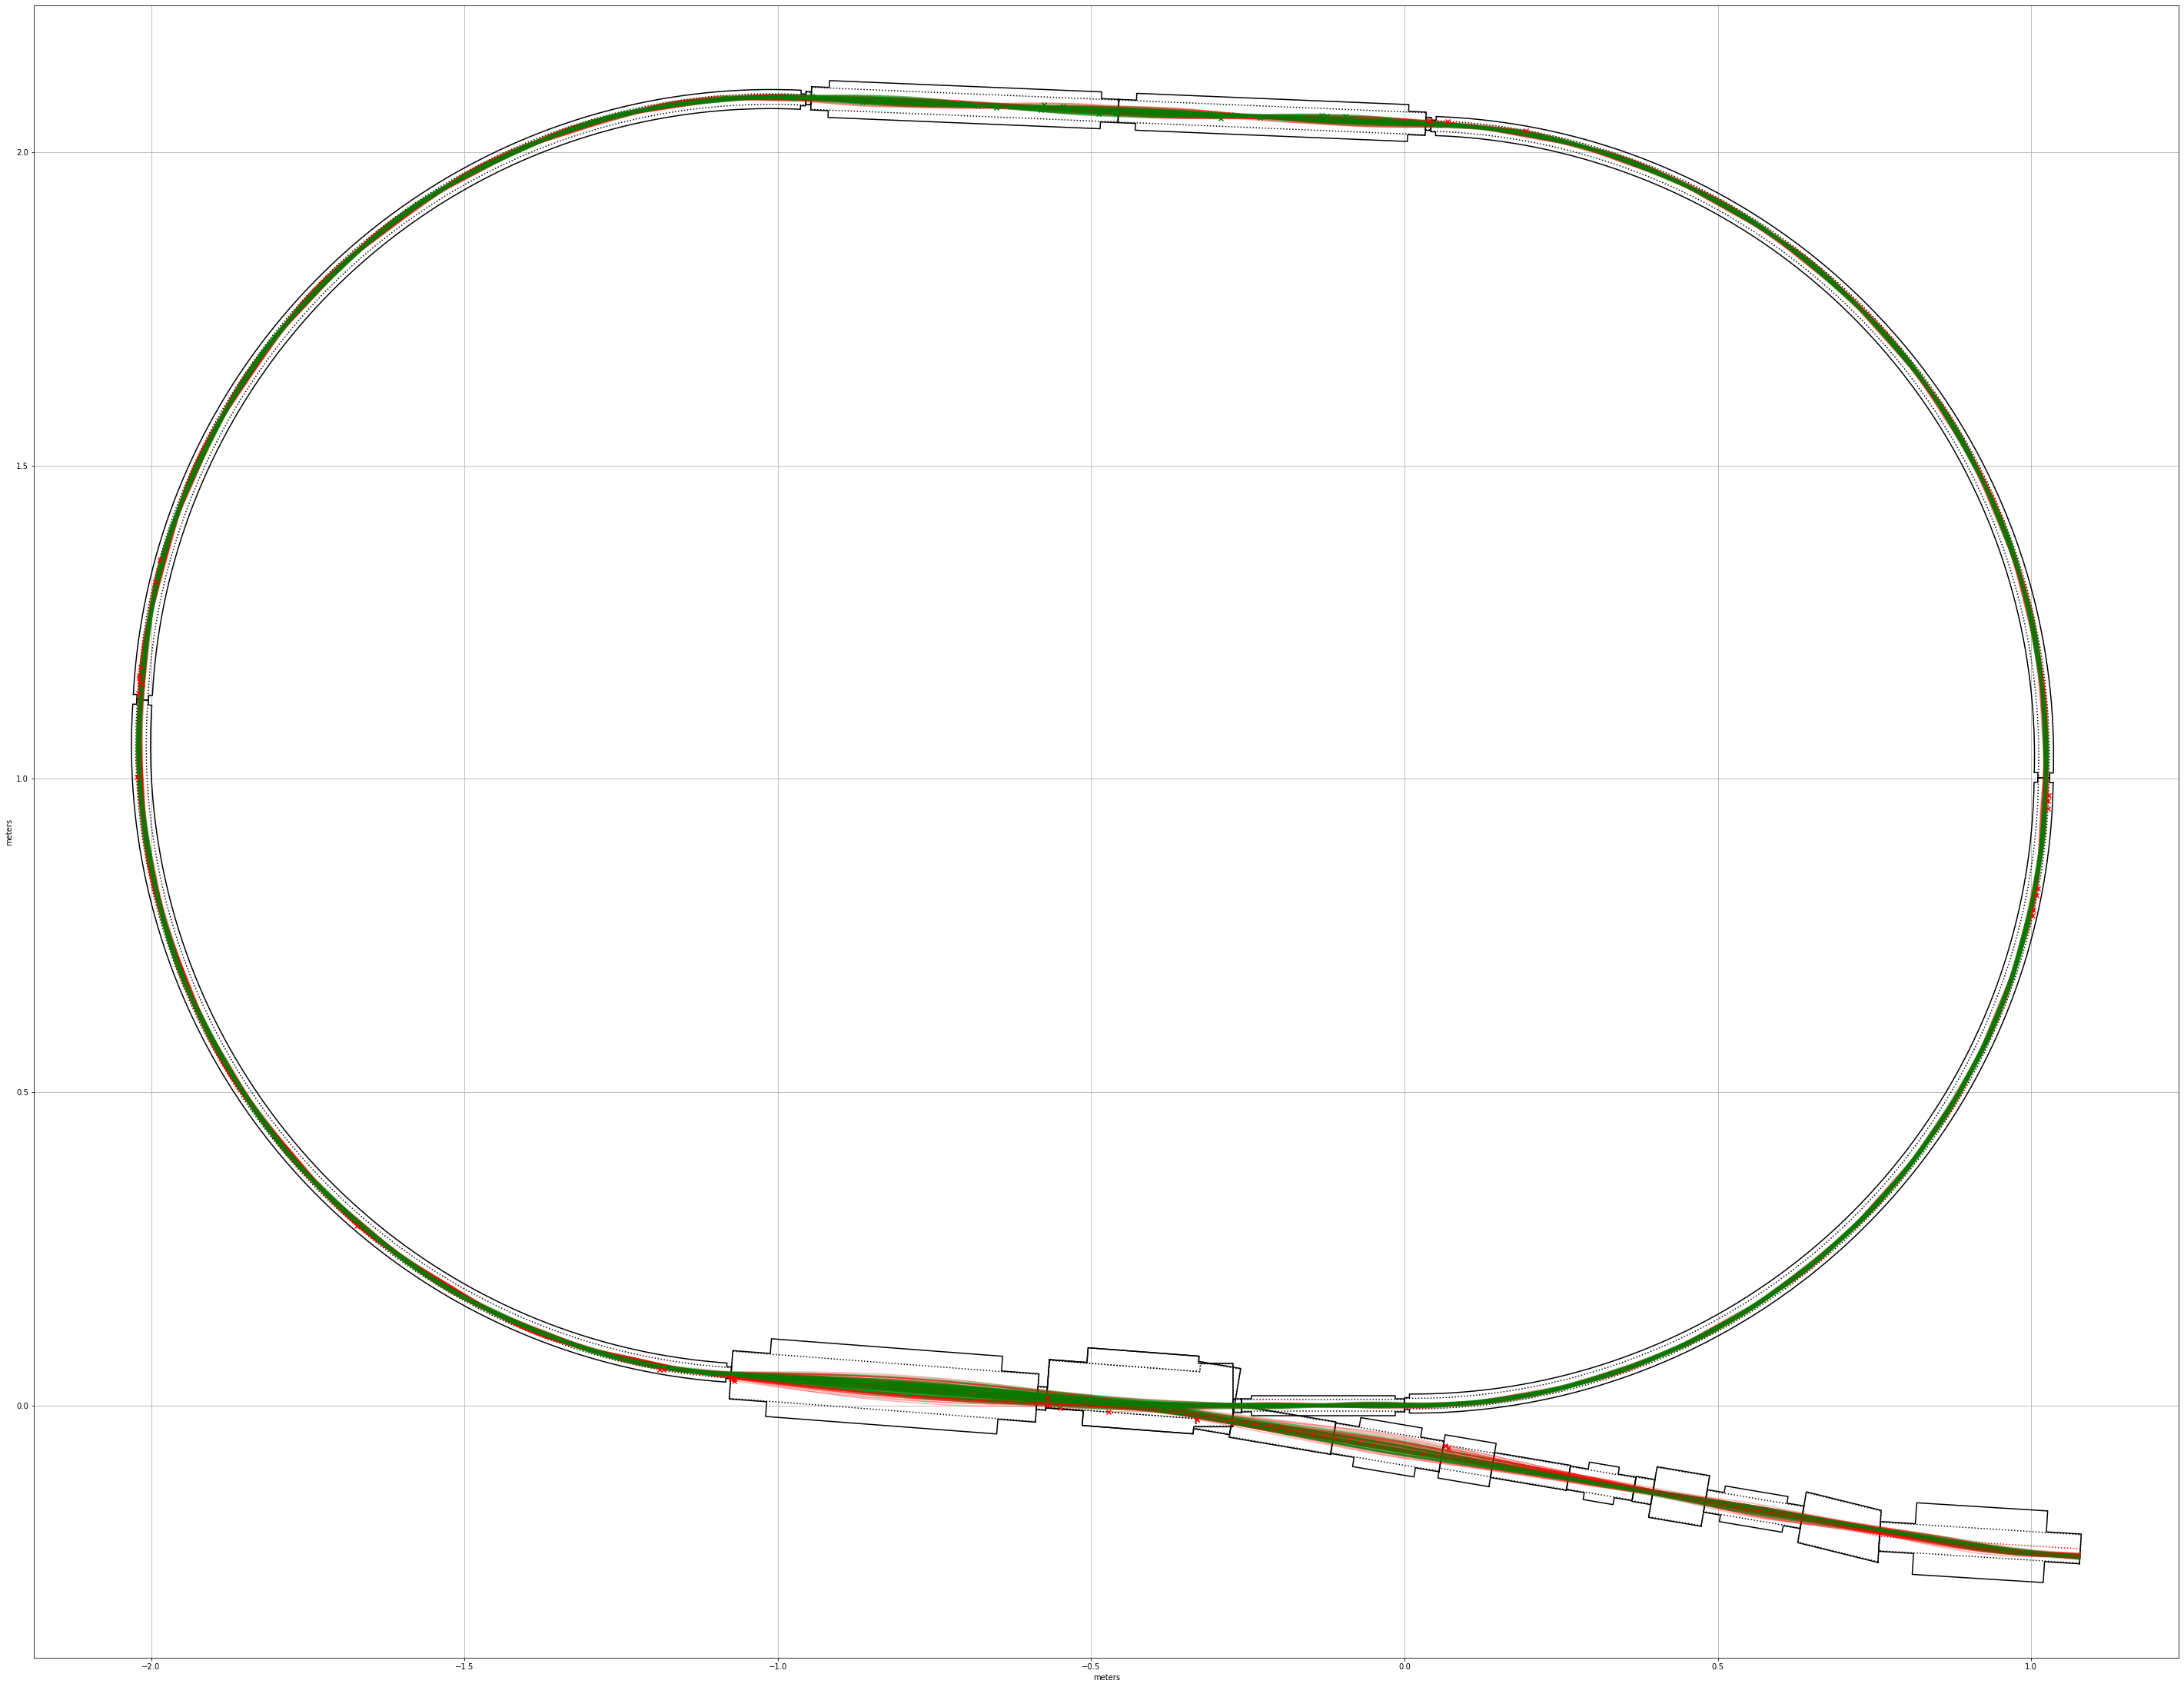

In [2]:
%matplotlib inline
plt.figure(figsize=(50,50))
model.show_floor_plan_with_trajectories(save_fig='layout_with_trajectories',T_max=.1)


In [13]:
index=8
1e2*model.lattice_injector.el_list[index].rp*2,1e2*model.lattice_injector.el_list[index].Lm,model.lattice_injector.el_list[index]

(5.062324756221503,
 9.93125789228476,
 <latticeElements.class_HalbachLensSim.HalbachLensSim at 0x147e27610>)

In [20]:
index=4
1e2*model.lattice_ring.el_list[index].rp*2,model.lattice_ring.el_list[index].Lm*1e2,model.lattice_ring.el_list[index]

(8.0,
 36.98710631014627,
 <latticeElements.class_HalbachLensSim.HalbachLensSim at 0x1479b8910>)

In [ ]:
index=0
(180/3.14)*model.lattice_ring.el_list[index].ang,1e2*model.lattice_ring.el_list[index].rp*2,model.lattice_ring.el_list[index].num_lenses,model.lattice_ring.el_list[index]

In [1]:
# %matplotlib tk
# model.show_floor_plan_with_trajectories(T_max=.1)
model.show_floor_plan()

NameError: name 'model' is not defined

In [135]:
from shapely.affinity import rotate, translate
import copy
def injector_shapes_in_ring_frame(model, shapes):
    ne_Inj, ne_Ring = model.lattice_injector.combiner.ne, model.lattice_ring.combiner.ne
    angle_injector = full_arctan2(ne_Inj[1], ne_Inj[0])
    angle_ring = full_arctan2(ne_Ring[1], ne_Ring[0])
    rotation_angle = angle_ring - angle_injector
    r2_injector = model.lattice_injector.combiner.r2
    r2_ring = model.lattice_ring.combiner.r2
    shapes_lab_frame=[]
    for shape in shapes:
        shape=copy.copy(shape)
        shape = translate(shape, xoff=-r2_injector[0], yoff=-r2_injector[1])
        shape = rotate(shape, rotation_angle, use_radians=True, origin=(0, 0))
        shape = translate(shape, xoff=r2_ring[0], yoff=r2_ring[1])
        shapes_lab_frame.append(shape)
    return shapes_lab_frame

In [141]:
def make_shapes(lattice):
    shapes_outer=[el.SO_outer for el in lattice]
    shapes_inner=[el.SO for el in lattice]
    shapes_trajectories=[make_trajectory_shape(el) for el in lattice]
    return shapes_inner,shapes_outer,shapes_trajectories
def make_injector_shapes_ring_frame(model):
    shapes_sequence=list(make_shapes(model.lattice_injector))
    for i,shapes in enumerate(shapes_sequence):
        shapes_sequence[i]=injector_shapes_in_ring_frame(model,shapes)
    return shapes_sequence


In [144]:
%matplotlib tk


shapes_inner,shapes_outer,shapes_trajectories=make_shapes(model.lattice_ring)
shapes_system=(make_shapes(model.lattice_ring),make_injector_shapes_ring_frame(model))
for [shapes_inner,shapes_outer,shapes_trajectories] in shapes_system:
    for shape in shapes_inner:
        plt.plot(*shape.exterior.xy,c='black',linestyle=':')
    for shape in shapes_outer:
        plt.plot(*shape.exterior.xy,c='black')
    for shape in shapes_trajectories:
        plt.plot(*shape.xy,c='red',linestyle=':')

# shapes.extend(model.injector_shapes_in_lab_frame(whichSide))
plt.gca().set_aspect('equal')
plt.show()